# EmoNet: Advanced Emotion Classification Using NLP Techniques

## Baseline Model

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Text,Emotion
0,i didnt feel humiliated,sorrow
1,i can go from feeling so hopeless to so damned...,sorrow
2,im grabbing a minute to post i feel greedy wrong,rage
3,i am ever feeling nostalgic about the fireplac...,care
4,i am feeling grouchy,rage


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     15000 non-null  object
 1   Emotion  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


In [5]:
data.shape


(15000, 2)

In [6]:
data.columns

Index(['Text', 'Emotion'], dtype='object')

In [7]:
# Check for null values in the DataFrame
null_values = data.isnull().any().any()

In [8]:
if null_values:
    print("There are null values in the DataFrame.")
else:
    print("There are no null values in the DataFrame.")

There are no null values in the DataFrame.


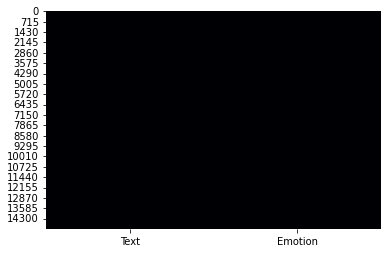

In [9]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

#### No null values are present in the data

In [10]:
data.describe().T

,count,unique,top,freq
Text,15000,14971,i was sitting in the corner stewing in my own ...,2
Emotion,15000,6,happiness,4989


In [11]:
data['Emotion'].value_counts()

happiness    4989
sorrow       4412
rage         2028
scare        1804
care         1226
amaze         541
Name: Emotion, dtype: int64

### Data Preprocessing

In [12]:
# Convert 'Emotion' column to categorical data type
data['Emotion_num'] = pd.Categorical(data['Emotion']).codes

In [13]:
data.head()

,Text,Emotion,Emotion_num
0,i didnt feel humiliated,sorrow,5
1,i can go from feeling so hopeless to so damned...,sorrow,5
2,im grabbing a minute to post i feel greedy wrong,rage,3
3,i am ever feeling nostalgic about the fireplac...,care,1
4,i am feeling grouchy,rage,3


In [14]:
data['Emotion'].value_counts()

happiness    4989
sorrow       4412
rage         2028
scare        1804
care         1226
amaze         541
Name: Emotion, dtype: int64

In [15]:
data['Emotion_num'].value_counts()

2    4989
5    4412
3    2028
4    1804
1    1226
0     541
Name: Emotion_num, dtype: int64

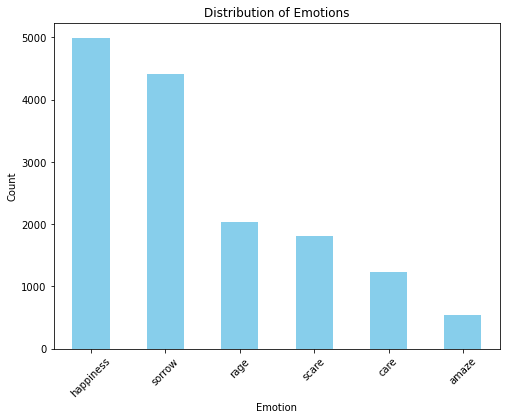

In [16]:
# Calculate the counts of each emotion
emotion_counts = data['Emotion'].value_counts()

# Plot the bar plot for emotion distribution
plt.figure(figsize=(8, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Train-test split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Emotion_num'], test_size=0.2, random_state=42)

## Random Forest

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer()

# Transform text data into TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train Random Forest classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_tfidf, y_train)

# Predict on the test set
rfc_y_pred = rfc.predict(X_test_tfidf)


In [21]:
print("Classification Report:\n", classification_report(y_test, rfc_y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.62      0.67        95
           1       0.84      0.68      0.75       255
           2       0.82      0.95      0.88       999
           3       0.91      0.80      0.85       409
           4       0.86      0.81      0.83       350
           5       0.91      0.89      0.90       892

    accuracy                           0.86      3000
   macro avg       0.85      0.79      0.81      3000
weighted avg       0.86      0.86      0.86      3000



In [196]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rfc, X_train_tfidf, y_train, cv=5)

In [197]:
# Print the score for each fold
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i} score: {score}")

# Calculate and print the average cross-validation score
average_cv_score = cv_scores.mean()
print(f"Average CV score: {average_cv_score}")

Fold 1 score: 0.8529166666666667
Fold 2 score: 0.8566666666666667
Fold 3 score: 0.8358333333333333
Fold 4 score: 0.8258333333333333
Fold 5 score: 0.8341666666666666
Average CV score: 0.8410833333333333


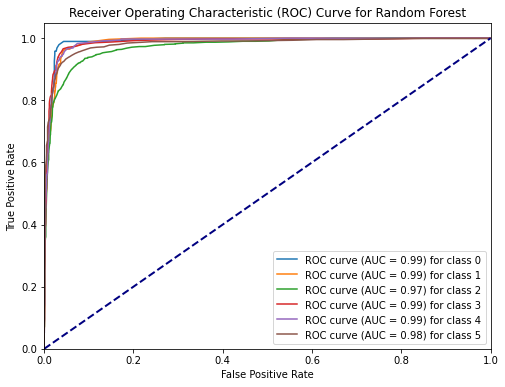

In [198]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
rfc_y_pred_proba = rfc.predict_proba(X_test_tfidf)

# Initialize lists to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate fpr, tpr, and auc for each class
for i in range(len(data['Emotion_num'].unique())):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, rfc_y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(data['Emotion_num'].unique())):
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()


In [199]:
from sklearn.metrics import roc_auc_score

# Initialize an empty list to store AUC scores for each class
auc_scores = []

# Calculate AUC score for each class
for i in range(len(data['Emotion_num'].unique())):
    auc_score = roc_auc_score(y_test == i, rfc_y_pred_proba[:, i])
    auc_scores.append(auc_score)

# Print the AUC scores
print("AUC Scores for Each Class:")
for i, auc_score in enumerate(auc_scores):
    print("Class {}: {:.4f}".format(i, auc_score))
# Calculate the average ROC curve score
avg_auc_score = np.mean(auc_scores)

# Print the average ROC curve score
print("Average ROC Curve Score:", avg_auc_score)

AUC Scores for Each Class:
Class 0: 0.9903
Class 1: 0.9877
Class 2: 0.9724
Class 3: 0.9871
Class 4: 0.9875
Class 5: 0.9811
Average ROC Curve Score: 0.9843726907823519


/Users/saisrikar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x504 with 0 Axes>

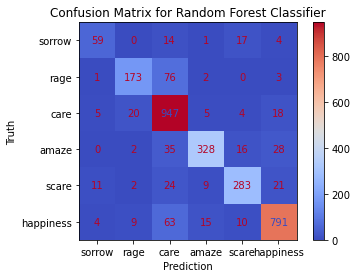

In [200]:
from sklearn.metrics import plot_confusion_matrix

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(rfc, X_test_tfidf, y_test, cmap='coolwarm', display_labels=data['Emotion'].unique())
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

## SVM

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer()

# Transform text data into TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train SVM classifier
svm = SVC(random_state=42)
svm.fit(X_train_tfidf, y_train)

# Predict on the test set
svm_y_pred = svm.predict(X_test_tfidf)


In [202]:
print("Classification Report:\n", classification_report(y_test, svm_y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.44      0.58        95
           1       0.88      0.54      0.67       255
           2       0.78      0.95      0.86       999
           3       0.94      0.72      0.82       409
           4       0.86      0.73      0.79       350
           5       0.86      0.92      0.89       892

    accuracy                           0.83      3000
   macro avg       0.86      0.72      0.77      3000
weighted avg       0.84      0.83      0.83      3000



In [203]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(svm, X_train_tfidf, y_train, cv=5)

In [204]:
# Print the score for each fold
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i} score: {score}")

# Calculate and print the average cross-validation score
average_cv_score = cv_scores.mean()
print(f"Average CV score: {average_cv_score}")

Fold 1 score: 0.7933333333333333
Fold 2 score: 0.7941666666666667
Fold 3 score: 0.7858333333333334
Fold 4 score: 0.7804166666666666
Fold 5 score: 0.7904166666666667
Average CV score: 0.7888333333333333


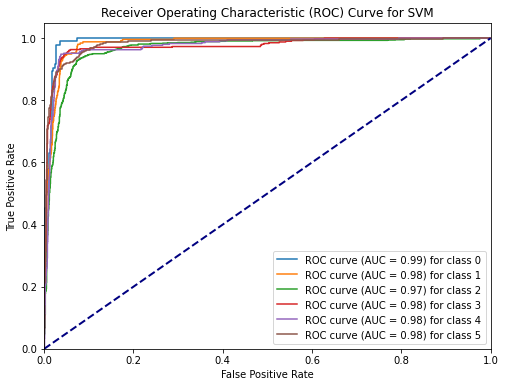

In [205]:
# Get predicted probabilities for each class
svm_y_pred_proba = svm.decision_function(X_test_tfidf)

# Initialize lists to store fpr, tpr, and auc for each class
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

# Calculate fpr, tpr, and auc for each class
for i in range(len(data['Emotion_num'].unique())):
    fpr_svm[i], tpr_svm[i], _ = roc_curve((y_test == i).astype(int), svm_y_pred_proba[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(data['Emotion_num'].unique())):
    plt.plot(fpr_svm[i], tpr_svm[i], label='ROC curve (AUC = %0.2f) for class %d' % (roc_auc_svm[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc="lower right")
plt.show()


In [206]:
from sklearn.metrics import roc_auc_score

# Initialize an empty list to store AUC scores for each class
auc_scores = []

# Calculate AUC score for each class
for i in range(len(data['Emotion_num'].unique())):
    auc_score = roc_auc_score(y_test == i, svm_y_pred_proba[:, i])
    auc_scores.append(auc_score)

# Print the AUC scores
print("AUC Scores for Each Class:")
for i, auc_score in enumerate(auc_scores):
    print("Class {}: {:.4f}".format(i, auc_score))
# Calculate the average ROC curve score
avg_auc_score = np.mean(auc_scores)

# Print the average ROC curve score
print("Average ROC Curve Score:", avg_auc_score)

AUC Scores for Each Class:
Class 0: 0.9900
Class 1: 0.9831
Class 2: 0.9657
Class 3: 0.9758
Class 4: 0.9751
Class 5: 0.9821
Average ROC Curve Score: 0.9786052574215267


/Users/saisrikar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x504 with 0 Axes>

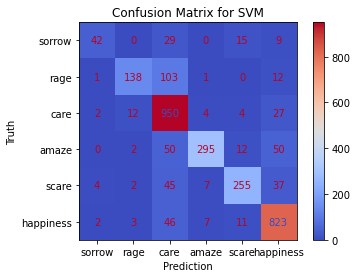

In [207]:
from sklearn.metrics import plot_confusion_matrix

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(svm, X_test_tfidf, y_test, cmap='coolwarm', display_labels=data['Emotion'].unique())
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix for SVM')
plt.show()

## Logistic Regression

In [216]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer()

# Transform text data into TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train Logistic Regression classifier
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_tfidf, y_train)

# Predict on the test set
log_reg_y_pred = log_reg.predict(X_test_tfidf)


/Users/saisrikar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [209]:
print("Classification Report:\n", classification_report(y_test, log_reg_y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.39      0.53        95
           1       0.86      0.60      0.71       255
           2       0.81      0.94      0.87       999
           3       0.93      0.76      0.84       409
           4       0.86      0.75      0.80       350
           5       0.85      0.93      0.89       892

    accuracy                           0.85      3000
   macro avg       0.86      0.73      0.77      3000
weighted avg       0.85      0.85      0.84      3000



In [210]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(log_reg, X_train_tfidf, y_train, cv=5)

/Users/saisrikar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/saisrikar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [211]:
# Print the score for each fold
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i} score: {score}")

# Calculate and print the average cross-validation score
average_cv_score = cv_scores.mean()
print(f"Average CV score: {average_cv_score}")

Fold 1 score: 0.8116666666666666
Fold 2 score: 0.8120833333333334
Fold 3 score: 0.8066666666666666
Fold 4 score: 0.8020833333333334
Fold 5 score: 0.8095833333333333
Average CV score: 0.8084166666666668


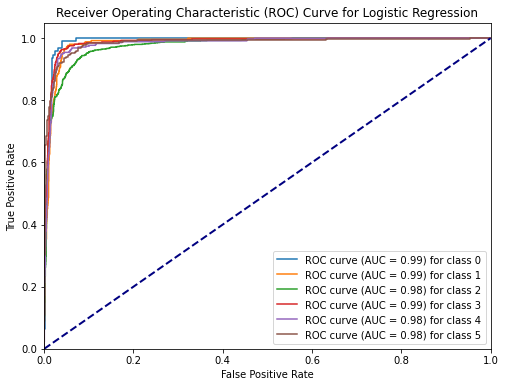

In [212]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for each class
log_reg_y_pred_proba = log_reg.predict_proba(X_test_tfidf)

# Initialize lists to store fpr, tpr, and auc for each class
fpr_log_reg = dict()
tpr_log_reg = dict()
roc_auc_log_reg = dict()

# Calculate fpr, tpr, and auc for each class
for i in range(len(data['Emotion_num'].unique())):
    fpr_log_reg[i], tpr_log_reg[i], _ = roc_curve((y_test == i).astype(int), log_reg_y_pred_proba[:, i])
    roc_auc_log_reg[i] = auc(fpr_log_reg[i], tpr_log_reg[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(data['Emotion_num'].unique())):
    plt.plot(fpr_log_reg[i], tpr_log_reg[i], label='ROC curve (AUC = %0.2f) for class %d' % (roc_auc_log_reg[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


In [213]:
from sklearn.metrics import roc_auc_score

# Initialize an empty list to store AUC scores for each class
auc_scores = []

# Calculate AUC score for each class
for i in range(len(data['Emotion_num'].unique())):
    auc_score = roc_auc_score(y_test == i, log_reg_y_pred_proba[:, i])
    auc_scores.append(auc_score)

# Print the AUC scores
print("AUC Scores for Each Class:")
for i, auc_score in enumerate(auc_scores):
    print("Class {}: {:.4f}".format(i, auc_score))
# Calculate the average ROC curve score
avg_auc_score = np.mean(auc_scores)

# Print the average ROC curve score
print("Average ROC Curve Score:", avg_auc_score)

AUC Scores for Each Class:
Class 0: 0.9912
Class 1: 0.9854
Class 2: 0.9766
Class 3: 0.9877
Class 4: 0.9834
Class 5: 0.9850
Average ROC Curve Score: 0.9848740450317716


/Users/saisrikar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x504 with 0 Axes>

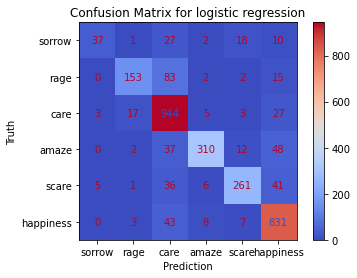

In [214]:
from sklearn.metrics import plot_confusion_matrix

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(log_reg, X_test_tfidf, y_test, cmap='coolwarm', display_labels=data['Emotion'].unique())
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix for logistic regression')
plt.show()

# <center><div style="font-family: Trebuchet MS; background-color: #E94B3C; color: #2D2926; padding: 12px; line-height: 1;">Algorithm Results Table for Baseline model</div></center>

|Sr. No.|ML Algorithm|Cross Validation Score|ROC AUC Score|Accuracy|
|-|-|-|-|-|
|1|Random Forest|85.01%|98.53%|86%|
|2|SVM Classifier|79.0%|97%|83%|
|3|Logistic Regression|80.24%|98.53%|85%|

# Overall, Accuracy for the Baseline model is 86% on train dataset

## External validation

In [28]:
testing_1 = pd.read_csv('test.csv')
testing_1.shape

(1000, 1)

In [29]:
testing_1.head()

,Text
0,i mean as a group thing it felt good to get in...
1,i feel drained mentally and physically and i r...
2,i often feel that they are not an extremely cl...
3,i am not wishing november away or trying to fo...
4,i feel stupid and thoughtless


In [30]:
X_test_count = tfidf.transform(testing_1['Text']) 

In [31]:
X_test_count.shape

(1000, 13179)

In [26]:
pred = rfc.predict(X_test_count)

In [27]:
print(pred)

[2 5 2 4 5 2 2 5 2 3 5 2 4 5 5 4 2 5 2 5 3 2 2 3 5 3 3 5 5 2 2 2 2 5 5 4 3
 2 2 5 5 2 2 1 4 4 2 2 5 2 4 4 5 3 4 2 5 5 5 2 2 2 2 5 2 5 5 0 2 3 2 4 2 4
 5 3 2 5 5 2 5 5 2 4 2 2 5 5 5 2 1 2 5 3 2 2 0 5 5 3 2 4 2 5 2 5 5 2 3 0 5
 5 2 2 0 2 5 5 1 2 2 5 2 3 5 1 5 2 3 5 3 5 2 2 3 2 2 5 4 5 5 5 2 2 2 2 2 2
 3 1 2 1 4 2 2 2 3 2 4 5 2 5 2 5 2 2 2 2 2 4 2 2 5 5 2 5 5 2 1 4 2 5 2 2 2
 2 2 3 5 3 5 5 2 3 1 5 2 1 3 4 3 5 1 4 2 5 1 4 2 5 2 5 2 2 3 4 1 2 5 5 4 3
 2 5 2 2 5 1 2 2 5 2 1 4 2 2 5 5 3 2 5 2 2 5 5 2 2 5 2 5 5 1 2 2 2 4 5 2 3
 2 4 2 2 3 1 3 2 3 1 5 5 2 5 5 2 5 5 4 4 5 2 2 2 5 5 0 4 5 2 2 1 2 2 5 2 2
 2 2 5 5 2 2 4 4 4 2 3 1 2 2 2 5 2 5 3 4 4 2 4 2 3 5 3 4 5 3 4 2 2 3 5 1 5
 5 2 1 1 4 4 5 2 1 2 2 5 5 5 5 2 2 2 2 4 2 2 0 1 3 5 1 2 2 1 4 3 4 5 5 2 2
 2 1 0 3 2 3 1 2 2 3 3 5 1 4 2 5 2 2 5 1 2 2 2 1 5 2 2 2 3 2 3 2 5 5 4 2 2
 1 4 2 3 2 3 3 2 2 0 5 2 0 4 2 2 5 2 2 5 3 5 3 2 3 2 3 4 2 2 4 4 2 2 4 5 5
 2 4 2 3 1 3 4 5 2 2 5 4 0 2 2 3 2 5 5 4 5 5 5 3 3 5 0 2 2 2 2 5 5 2 2 2 5
 3 5 4 4 2 5 5 4 4 2 5 4 

In [234]:
manual_mapping = {0: "amaze", 1: "care", 2: "happiness", 3: "rage", 4: "scare", 5: "sorrow"}
# Convert numerical predictions to room types using manual mapping
pred_labels_mapped = [manual_mapping[label] for label in pred]

In [235]:
print(pred_labels_mapped)

['happiness', 'sorrow', 'happiness', 'scare', 'sorrow', 'happiness', 'happiness', 'sorrow', 'happiness', 'rage', 'sorrow', 'happiness', 'scare', 'sorrow', 'sorrow', 'scare', 'happiness', 'sorrow', 'happiness', 'sorrow', 'rage', 'happiness', 'happiness', 'rage', 'sorrow', 'rage', 'rage', 'sorrow', 'sorrow', 'happiness', 'happiness', 'happiness', 'happiness', 'sorrow', 'sorrow', 'scare', 'rage', 'happiness', 'happiness', 'sorrow', 'sorrow', 'happiness', 'happiness', 'care', 'scare', 'scare', 'happiness', 'happiness', 'sorrow', 'happiness', 'scare', 'scare', 'sorrow', 'rage', 'scare', 'happiness', 'sorrow', 'sorrow', 'sorrow', 'happiness', 'happiness', 'happiness', 'happiness', 'sorrow', 'happiness', 'sorrow', 'sorrow', 'amaze', 'happiness', 'rage', 'happiness', 'scare', 'happiness', 'scare', 'sorrow', 'rage', 'happiness', 'sorrow', 'sorrow', 'happiness', 'sorrow', 'sorrow', 'happiness', 'scare', 'happiness', 'happiness', 'sorrow', 'sorrow', 'sorrow', 'happiness', 'care', 'happiness', 'so

In [236]:
# Step 5: Save the predictions as a CSV file
submission = pd.DataFrame({'Emotion': pred_labels_mapped})

In [237]:
submission.to_csv("baselinesubmission.csv", index=False)

In [238]:
y_test = pd.read_csv('solution.csv')

In [239]:
from sklearn.metrics import balanced_accuracy_score

def model_evaluation(y_test, y_pred):
    # Calculate the balanced accuracy score
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Return the balanced accuracy as a single digit number
    print('The Balanced accuracy is : ', balanced_accuracy)

In [243]:
test_score = model_evaluation(y_test,pred_labels_mapped)

The Balanced accuracy is :  0.8025451959503503


## Balanced accuracy score for baseline model on test dataset(hidden label) is found to be 80%

In [9]:
y_test = pd.read_csv('solution.csv')
y_pred_baseline = pd.read_csv('baselinesubmission.csv')
y_pred_intermediate = pd.read_csv('intermediatesubmission.csv')

In [10]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_test, y_pred_baseline))
print(balanced_accuracy_score(y_test, y_pred_intermediate))

0.8025451959503503
0.8510647369407343


In [11]:
from sklearn.metrics import balanced_accuracy_score

def evaluation_metrics(y_test, y_pred):
    score = balanced_accuracy_score(y_test, y_pred)
    return score

def get_score(y_test, y_pred, lower_bound = 0.5333, upper_bound = 0.866, full_marks = 30):
    assert lower_bound is not None, "lower bound should be given"
    assert upper_bound is not None, "upper bound should be given"
    score = evaluation_metrics(y_test, y_pred)
    if score < lower_bound:
        return 0
    elif score > upper_bound:
        return full_marks
    else:
        return full_marks * (score - lower_bound) / (upper_bound - lower_bound)


In [12]:
print("Baseline Predictions Autograder Score: ", get_score(y_test, y_pred_baseline))
print("Intermediate Predictions Autograder Score ", get_score(y_test, y_pred_intermediate))

Baseline Predictions Autograder Score:  24.27819620832735
Intermediate Predictions Autograder Score  28.65326753297874
